In [1]:
import pandas as pd
data_path = 'uservoice_sample.csv'
df_init = pd.read_csv(data_path)

In [2]:
import re

In [3]:
df_init.head()

,txt,txt_norm
0,"""Администратор, прошу опубликуйте! Дорогие р...","""весь также будущее по спикер дорогой ананян г..."
1,"""Почему я и мои мастера не выезжают ""посмотрет...","""заказ даже такой по ванна мастер современный ..."
2,"""16 March 2023, 23:43 Что происходит объяв...","""review всё личка такой допишешся написать 202..."
3,"""26 December, 2022 При поиске работы объяв...","""по при ранний невозможно december разработчик..."
4,"""09 February 2023, 10:25 Прошел проверку н...","""пройти review создать политика 2023 же is act..."


In [4]:
def islatin(sym):
    return sym>='a'and sym<='z'

In [5]:
def isdigit(sym):
    return sym>='0' and sym <='9'

In [6]:
isdigit('0')

True

In [7]:
df_init['txt'] = list(map(lambda x: str(x).lower(), list(df_init['txt'] )))
df_init['txt'] = list(map(lambda x: x.replace('ё', 'е'), list(df_init['txt'] )))
df_init['txt'] = list(map(lambda x: re.sub('\[[^)]*\]', '', x), list(df_init['txt'] )))
# records['txt_norm'] = list(map(lambda x: '"'+x+'"', list(records['txt_norm'] )))
df_init['txt'] = list(map(lambda x: x.encode('cp1251', errors='ignore').decode('cp1251'), list(df_init['txt'] )))
df_init['txt'] = list(map(lambda x: x[1:len(x)-1], list(df_init['txt'] )))
df_init['txt'] = list(map(lambda x: "".join([w for w in x if not isdigit(w)]), list(df_init['txt'] )))
df_init['txt'] = list(map(lambda x: "".join([w for w in x if not islatin(w)]), list(df_init['txt'] )))

In [8]:
df_init['txt_norm'] = list(map(lambda x: str(x).lower(), list(df_init['txt_norm'] )))
df_init['txt_norm'] = list(map(lambda x: x.replace('ё', 'е'), list(df_init['txt_norm'] )))
df_init['txt_norm'] = list(map(lambda x: re.sub('\[[^)]*\]', '', x), list(df_init['txt_norm'] )))
# records['txt_norm'] = list(map(lambda x: '"'+x+'"', list(records['txt_norm'] )))
df_init['txt_norm'] = list(map(lambda x: x.encode('cp1251', errors='ignore').decode('cp1251'), list(df_init['txt_norm'] )))
df_init['txt_norm'] = list(map(lambda x: x[1:len(x)-1], list(df_init['txt_norm'] )))
df_init['txt_norm'] = list(map(lambda x: "".join([w for w in x if not isdigit(w)]), list(df_init['txt_norm'] )))
df_init['txt_norm'] = list(map(lambda x: "".join([w for w in x if not islatin(w)]), list(df_init['txt_norm'] )))

In [9]:
df_init['txt_norm']

0        весь также будущее по спикер дорогой ананян го...
1        заказ даже такой по ванна мастер современный п...
2         все личка такой допишешся написать  же продав...
3        по при ранний невозможно  разработчик  один оч...
4        пройти  создать политика  же   удалить   разны...
                               ...                        
22213    легализация   все отправка придумать недалекий...
22214     решить   оценить линия   поддержка  ваш вопро...
22215     по просить   поддержка разобраться миша реакц...
22216    сфера ведение по сеть звонить коммуникабельнос...
22217    невзламывать на друг вы не заблокировать кто н...
Name: txt_norm, Length: 22218, dtype: object

In [16]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [17]:
# inputs = tokenizer("шляпа-доставка! авито доставка:", return_tensors="pt")
# outputs = model(**inputs)

In [10]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')  # multi-language model

In [11]:
sentences = df_init['txt']
embedding = model.encode(sentences, convert_to_tensor=False)
embedding.shape

(22218, 384)

In [12]:
embedding

array([[ 0.02236579, -0.07478554, -0.06094347, ..., -0.02912958,
        -0.17586197,  0.03046287],
       [ 0.03791523,  0.05426043,  0.10739622, ...,  0.05990028,
        -0.11676306, -0.10961503],
       [ 0.01612015,  0.06466454, -0.07763744, ..., -0.05076247,
         0.04882237,  0.05972154],
       ...,
       [-0.24115212,  0.10204361, -0.01274201, ...,  0.06595826,
        -0.15719214,  0.09643795],
       [ 0.00407208,  0.10857359,  0.15204513, ...,  0.0396923 ,
        -0.1384075 ,  0.20356297],
       [-0.14606604,  0.07120281,  0.19343151, ...,  0.08865872,
        -0.15563424,  0.0290323 ]], dtype=float32)

Очистка от повторяющихся супер похожих спамных и рекламных объявлений с помощью dbscan

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [14]:
logs = []
epsilon = 0.5
for i in range(11):
    print(epsilon)
    
    dbscan = DBSCAN(eps=epsilon)
    dbscan.fit(embedding)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
  
    elements_in_class = list(map(lambda i: sum(1 for ind in dbscan.labels_ if ind == i), set(dbscan.labels_)))[:-1]
    mean_elements_in_class = np.mean(elements_in_class)

    print('Mean number of elements in class: %0.3f' % mean_elements_in_class)
    print('Max number of elements in class: %0.3f' % np.max(elements_in_class))
    print('Min number of elements in class: %0.3f' % np.min(elements_in_class))
    
    sil = silhouette_score(embedding, labels)
    print("Silhouette Coefficient: %0.3f" % sil)
    
    print('================================')
    
    logs.append([epsilon, n_clusters_, n_noise_, mean_elements_in_class, np.max(elements_in_class), np.min(elements_in_class), sil])
    
    
    epsilon+=0.2

0.5


KeyboardInterrupt: 

In [23]:
log_df = pd.DataFrame(logs, columns = ['eps', 'n_clusters', 'n_noise_points', 'mean n_elements', 'max n_elements','min n_elements', 'silhouette'])

In [24]:
log_df

,eps,n_clusters,n_noise_points,mean n_elements,max n_elements,min n_elements,silhouette
0,0.5,36,21583,17.638889,161,5,-0.183392
1,0.7,47,21405,17.297872,187,5,-0.193278
2,0.9,52,21161,20.326923,189,4,-0.193371
3,1.1,55,20905,23.872727,225,5,-0.206917
4,1.3,62,20466,28.258065,311,5,-0.192878
5,1.5,88,19776,27.750000,391,5,-0.206018
6,1.7,105,16871,50.923810,3802,2,-0.211542
7,1.9,52,10553,224.326923,11167,3,-0.143609
8,2.1,16,5056,1072.625000,17018,3,-0.053443
9,2.3,6,1974,3374.000000,20211,4,0.017535


In [15]:
dbscan = DBSCAN(eps=1.1)
dbscan.fit(embedding)

DBSCAN(eps=1.1)

In [16]:
elements_in_class = list(map(lambda i: sum(1 for ind in dbscan.labels_ if ind == i), set(dbscan.labels_)))[:-1]
np.argmax(elements_in_class)

2

In [17]:
list(sentences[[i == 8 for i in dbscan.labels_]])[2]

'здравствуйте,  \n пользователь     \n написал вам личное сообщение: \n \nа из за чего вообще опять это произошло?  \n  ответить\n на данное сообщение  \n  отписаться от новых сообщений можно в  \nличном кабинете'

In [28]:
# import numpy as np
# from sklearn import metrics


# labels = dbscan.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)

# mean_elements_in_class = np.mean(list(map(lambda i: sum(1 for ind in dbscan.labels_ if ind == i), set(dbscan.labels_)))[:-1])

# print('Mean number of elements in class: %0.3f' % mean_elements_in_class)

In [29]:
# for i, ind in enumerate(dbscan.core_sample_indices_):
#     print([sentences[ind], dbscan.labels_[ind]])

In [18]:
df_init = df_init[[i == -1 for i in dbscan.labels_]]

In [19]:
df_init.reset_index(inplace=True, drop=True)

In [20]:
df_init

,txt,txt_norm
0,"почему я и мои мастера не выезжают ""посмотреть...",заказ даже такой по ванна мастер современный п...
1,", : что происходит объявления продавцов ...",все личка такой допишешся написать же продав...
2,", при поиске работы объявления идут спис...",по при ранний невозможно разработчик один оч...
3,", : прошел проверку на двух аккаунтах с ...",пройти создать политика же удалить разны...
4,"добрый день! возможно ли такое, что работа про...",такой по столько просмотр минимум человек б...
...,...,...
20900,", : карта местности стала коряво стала р...",бесполезно показываться работать стать ...
20901,", : шляпа-доставка! авито доставка: в пр...",легализация все отправка придумать недалекий...
20902,здравствуйте еще в пятницу заблокировали профи...,по просить поддержка разобраться миша реакц...
20903,описание работодателя: требуется менеджер по п...,сфера ведение по сеть звонить коммуникабельнос...


In [21]:
sentences = sentences[[i == -1 for i in dbscan.labels_]]

In [22]:
embedding = embedding[[i == -1 for i in dbscan.labels_]]

In [23]:
sentences.reset_index(inplace=True, drop=True)
sentences

0        почему я и мои мастера не выезжают "посмотреть...
1          , :     что происходит объявления продавцов ...
2         ,      при поиске работы объявления идут спис...
3          , :     прошел проверку на двух аккаунтах с ...
4        добрый день! возможно ли такое, что работа про...
                               ...                        
20900      , :     карта местности стала коряво стала р...
20901      , :     шляпа-доставка! авито доставка: в пр...
20902    здравствуйте еще в пятницу заблокировали профи...
20903    описание работодателя: требуется менеджер по п...
20904    не кто меня не взламывал как вы не поймете это...
Name: txt, Length: 20905, dtype: object

In [24]:
len(embedding)

20905

In [25]:
!pip install scikit-learn-extra

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn_extra.cluster import KMedoids
# kmeans_kwargs = {
#      "init": "random",
#      #"n_init": 3 ,
#      "max_iter": 1000,
#      "random_state": 42,
# }

# A list holds the SSE values for each k
sse = []
silhouette_coefficients = []

# for k in range(2, 21):
kmeans = AgglomerativeClustering(n_clusters=14,linkage='ward').fit(embedding)
#sse.append(kmeans.inertia_)
score = silhouette_score(embedding, kmeans.labels_)
silhouette_coefficients.append(score)
    

In [31]:
silhouette_coefficients

[0.012939417]

In [42]:
elements_in_class = list(map(lambda i: sum(1 for ind in dbscan.labels_ if ind == i), set(dbscan.labels_)))[:-1]
mean_elements_in_class = np.mean(elements_in_class)

In [43]:
np.mean(elements_in_class)

23.87272727272727

In [50]:
len(sentences)

20905

In [51]:
len(kmeans.labels_)

20905

Elbow point at 7 clusters


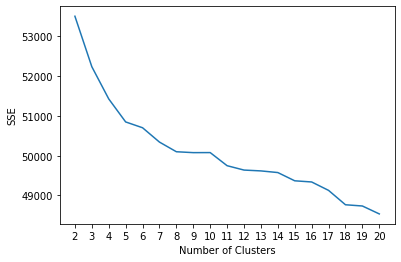

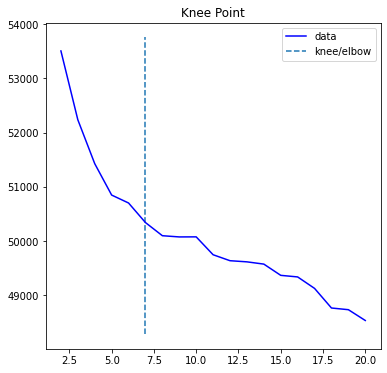

In [85]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

kl = KneeLocator(
range(2, 21), sse, curve="convex", direction="decreasing"
)

print('Elbow point at ' + str(kl.elbow) + ' clusters')
plt.plot(range(2, 21), sse)
plt.xticks(range(2, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
kl.plot_knee()

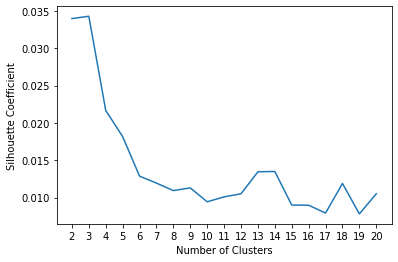

In [86]:
plt.plot(range(2, 21), silhouette_coefficients)
plt.xticks(range(2, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [65]:
final_model = KMedoids(
    init="random",
    n_clusters=14,
    #n_init=20,
    max_iter=1000,
    random_state=42
    )

final_model.fit(embedding)

KMedoids(init='random', max_iter=1000, n_clusters=14, random_state=42)

In [40]:
sentences[0]
final_model.labels_[7]

2

In [43]:
# for i,key in enumerate(list(final_model.labels_)):
#     if(key == 6):
#         print(i)
#         print(sentences[i])
#         print('--------------')

In [44]:
# [np.linalg.norm(centroids[0]-e) for e in embedding]

In [32]:
final_model = kmeans

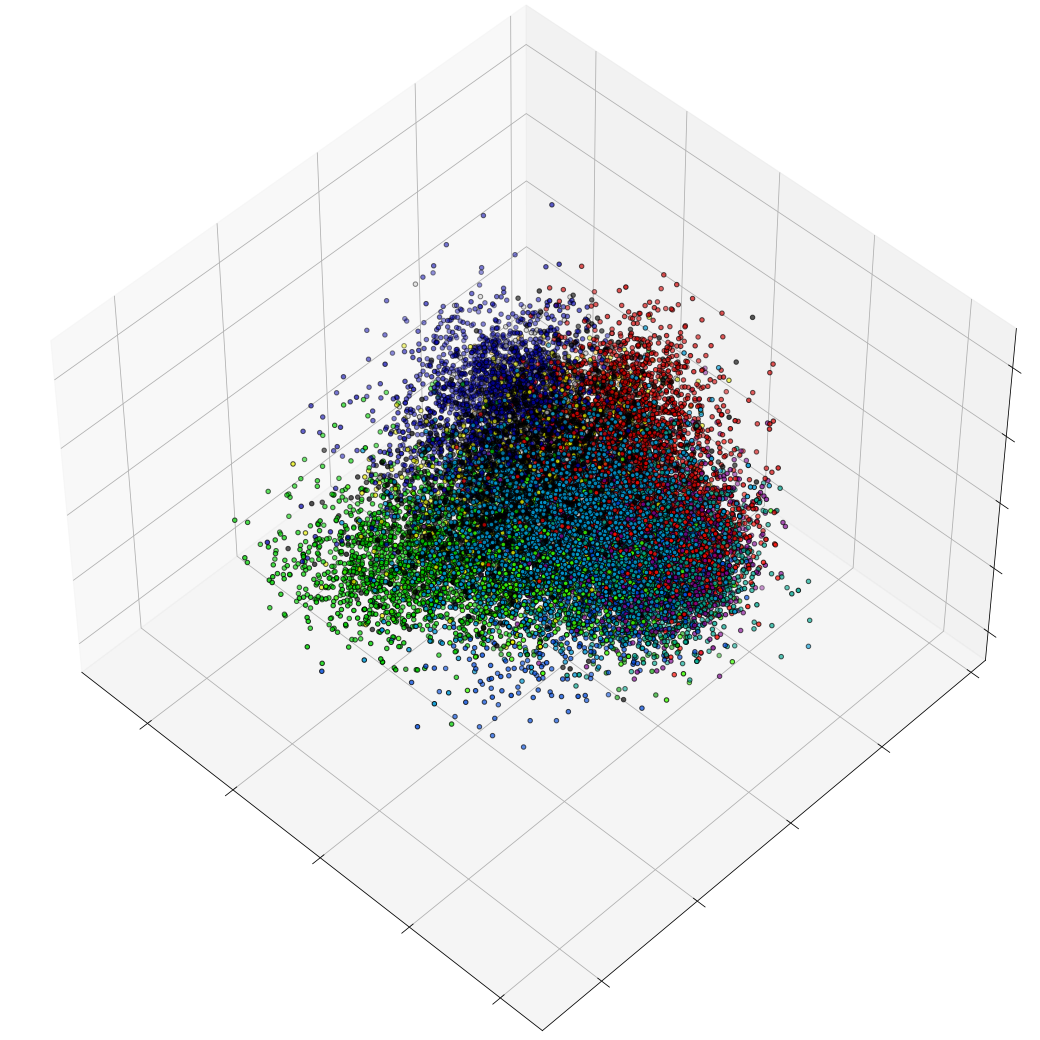

In [52]:
from sklearn.decomposition import PCA as sklearnPCA
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
from sklearn import decomposition

features_matrix = []
for tensor in embedding:
    features_matrix.append([float(elem) for elem in tensor])
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(features_matrix)
X = pca.transform(features_matrix)

# Reorder the labels to have colors matching the cluster results
y = kmeans.labels_
ax.scatter(X[:, 0], X[:, 1], X[:, 2],c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()


In [33]:
centroids = final_model.cluster_centers_
for i, center in enumerate(centroids):
    print(i)
    ind = np.argmin([np.linalg.norm(center-e) for e in embedding])
    print(sentences[ind])
    print('===========')

AttributeError: 'AgglomerativeClustering' object has no attribute 'cluster_centers_'

In [53]:
sentence_labels = []
for i in range(len(sentences)):
    sentence_labels.append([sentences[i], df_init['txt_norm'][i], embedding[i], final_model.labels_[i]])

In [54]:
sentence_labels_df = pd.DataFrame(sentence_labels, columns = ['sentence', 'norm_sent' ,'embedding', 'cluster_index'])
sentence_labels_df[20:30]

,sentence,norm_sent,embedding,cluster_index
20,", не грузятся фотографии! обновила и ни...",ничего в и не грузиться фотка фотография пер...,"[-0.059359252, -0.04178984, 0.05845806, -0.049...",6
21,", : фото приложение не грузит фото. п...",листать мера приложение тупить ле...,"[-0.109888576, 0.1504324, 0.06485387, 0.112482...",6
22,здравствуйте. не получается дозвониться в вашу...,техподдержка личка снимать так именно комната ...,"[0.03623296, 0.11120635, -0.004689417, 0.01773...",6
23,исправите уже наконец поиск - объявления в нов...,пройти иркутск по наконец при исправить город ...,"[0.14883022, -0.26735553, -0.0017146841, -0.05...",8
24,тема: \nвремя: .. в : (+) \nсобытие: пришло с...,техподдержка мама время дорогой так же тема ...,"[0.17632805, 0.043457706, -0.08745389, -0.0093...",0
25,"здравствуйте, у моего мужа заблокировался акка...",заказ появиться отправить муж подтверждение р...,"[0.03900304, 0.122995794, -0.2770392, -0.03525...",13
26,здравствуйте! рассмотрите пожалуйста возможнос...,пожалуйста избранный категория вернуть спасибо...,"[-0.09553714, 0.020552745, 0.12987073, 0.12687...",3
27,"кто желает писать отзывы авито по рублей, янд...",отзыв по желать яндекс присоединяться писать...,"[-0.28169742, -0.19663589, -0.05729916, -0.071...",1
28,", вылетает учетная запись. много раз пи...",убрать служба все шаблонный превью просмотр ...,"[-0.17101805, -0.25781098, -0.06797808, -0.168...",7
29,в энгельсе продают любвеобильных енотов на с...,дрессировка область дальнейший пользователь по...,"[0.12095468, -0.13496637, -0.07953863, 0.10459...",5


In [55]:
{label: dict() for label in list(set(final_model.labels_))}

{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {}}

In [56]:
stopw = ['такой','свой','мой', 'ваш', 'какой', 'уже', 'тот', 'нет', 'быть', 'cам', 'один', 'вообще', 'стать', 'очень', 'который', 'там', 'раз', 'каждый', 'какой', 'че', 'наш', 'весь', 'есть','этот']

In [57]:
print('весь' in stopw)

True


In [58]:
import pymorphy2
def getfreq(sentence_labels_df, final_model):
    morph = pymorphy2.MorphAnalyzer()
    labels = final_model.labels_
    freq_dict = {label: dict() for label in list(set(labels))}
    for i, sent in enumerate(sentence_labels_df['norm_sent']):
        sent = set(sent.split(' '))
        for word in sent:
            w = morph.parse(word)[0]
            if (not w.tag.POS in ('PREP', 'PRCL', 'CONJ', 'NPRO', 'INTJ',  None)) and (not word in stopw):
                cluster_index = sentence_labels_df['cluster_index'][i]
                if word in freq_dict[cluster_index].keys():
                    freq_dict[cluster_index][word]+=1
                else:
                    freq_dict[cluster_index][word]=1 
    return freq_dict

In [59]:
freq_dict = getfreq(sentence_labels_df,final_model)

In [60]:
def printtopN(freq_dict, N, final_model):
    for tag in list(set(final_model.labels_)):
        print(tag)
        for w in sorted(freq_dict[tag], key=freq_dict[tag].get, reverse=True)[:N]:
            print(w, freq_dict[tag][w])
        print('=============')

In [61]:
printtopN(freq_dict, 10, final_model)

0
авить 1328
объявление 1309
сообщение 851
поддержка 770
писать 582
день 514
деньга 498
время 492
отзыв 490
профиль 485
1
авить 1275
объявление 474
человек 409
год 405
день 401
мочь 371
писать 357
можно 315
еще 307
только 293
2
заблокировать 1203
аккаунт 1197
профиль 1137
авить 938
объявление 665
номер 584
поддержка 493
немочь 465
телефон 443
писать 431
3
авить 530
работа 383
клиент 238
объявление 228
работать 212
можно 206
опыт 201
продажа 199
день 198
реклама 182
4
авить 1347
объявление 1214
деньга 664
товар 545
приложение 544
реклама 535
человек 526
только 498
мошенник 428
мочь 418
5
авить 1242
цена 519
доставка 473
можно 379
мочь 376
объявление 350
новый 336
год 308
фото 301
продажа 301
6
видео 342
фото 330
авить 320
объявление 281
смотреть 180
фотография 128
мочь 93
можно 83
сделать 80
приложение 75
7
приложение 1130
объявление 513
обновление 451
работать 283
авить 259
избранный 218
последний 212
проблема 199
ошибка 183
поиск 180
8
поиск 387
объявление 287
город 228
приложение 152

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

def build_corpus(freq_dict, final_model):
    corpus = []
    for tag in list(set(final_model.labels_)):
        tag_str = ' '.join(list(map(lambda x: (x+' ')*freq_dict[tag][x],freq_dict[tag].keys())))
        corpus.append(tag_str)
    return corpus

In [63]:
corpus = build_corpus(freq_dict, final_model)

In [64]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = list(set(final_model.labels_)))
tfidf_df 

,аааааа,ааааааа,ааааааааааааа,ааааааанглийский,ааалеий,ааитодоставка,аакаунт,аант,аарон,аато,...,яха,яхина,яхрома,яхта,яхтенный,ячейка,яшин,яшноустресс,ящик,яяять
0,0.000776,0.000776,0.000000,0.000776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000944,0.00000
1,0.000000,0.000000,0.001056,0.000000,0.001056,0.000000,0.000813,0.000000,0.001056,0.000000,...,0.001056,0.000000,0.002112,0.000813,0.000000,0.000813,0.003168,0.000000,0.002142,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001396,0.00086
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000789,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000608,0.000000,0.000000,0.001920,0.00000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000848,0.000000,0.000000,0.000000,0.001101,0.003574,0.00000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003416,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001386,0.00000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001417,0.00000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001544,0.00000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002330,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [65]:
def printtopNTFIDF(freq_dict,N, final_model):
    for tag in list(set(final_model.labels_)):
        print(tag)
        for i in sorted(tfidf_df.loc[tag].index, key = tfidf_df.loc[tag].get, reverse=True)[:N]:
            print(i, tfidf_df.loc[tag][i])
        print("======")

In [66]:
printtopNTFIDF(freq_dict, 10, final_model)

0
авить 0.34163771143121613
объявление 0.3367498224875466
сообщение 0.218925973213829
поддержка 0.1980881308750274
писать 0.14972375606398178
день 0.13223025879190142
деньга 0.12811414178670605
время 0.12657059790975778
отзыв 0.12605608328410836
профиль 0.12476979671998481
1
авить 0.446543644255092
объявление 0.16600916657012832
человек 0.14324419647084913
год 0.1418432752339704
день 0.14044235399709168
мочь 0.12993544472050128
писать 0.12503222039142575
можно 0.1103225474041992
еще 0.10752070493044176
только 0.10261748060136625
2
заблокировать 0.3431733005278126
аккаунт 0.34146171299400807
профиль 0.32434583765596253
авить 0.2675781844514449
объявление 0.1897009516633378
номер 0.16659451995697636
поддержка 0.14063544236094067
немочь 0.13264803386985274
телефон 0.1263722129125694
писать 0.1229490378449603
3
авить 0.3016892765471249
работа 0.2180131941840544
опыт 0.1399450338018156
клиент 0.13547556192116175
обучение 0.12985996849593562
объявление 0.1297833114202726
работать 0.120675710

In [60]:
# df2 = pd.DataFrame(list(final_model.labels_))
# df2 = df2.rename(columns={0: "cluster_index"})
# df2

# df_final = pd.concat([df_init, df2], sort=False, axis = 1)
# df_final['cluster_index'] +=1
# df_final.head()

# indexes = df_final['cluster_index']

# indexes = pd.get_dummies(indexes)
# for ind in range(num_cluster):
#     indexes = indexes.rename(columns={ind: f"is_in_cluster_{ind}"})
# # indexes = indexes.rename(columns={1: "is_in_cluster_1", 2: "is_in_cluster_2"})

# df_binary_feature = pd.concat([df_final, indexes], sort=False, axis = 1)
# df_binary_feature.head()

In [80]:
df_init.to_csv('df_after_dbscan_medoids.csv')

In [81]:
df_embedding = pd.DataFrame(columns = ['sentence', 'embedding', 'cluster_index'])
df_embedding['sentence'] = list(sentences)
df_embedding['embedding'] = list(embedding)
df_embedding['cluster_index']=list(sentence_labels_df['cluster_index'])

In [63]:
df_embedding.to_csv('df_after_dbscan_medoids.csv')

KeyboardInterrupt: 